In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque
import random

In [2]:
class Q(nn.Module):
    def __init__(self, state_space, action_space):
        super(Q, self).__init__()
        self.fc1 = nn.Linear(state_space,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,action_space)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        Q_values = self.fc3(x)
        
        return Q_values

In [3]:
def epsilon_greedy(Q_values, action_space, epsilon):
    if np.random.rand() <= epsilon: ## 0~1의 균일분포 표준정규분포 난수를 생성. 정해준 epsilon 값보다 작은 random 값이 나오면 
        action = random.randrange(action_space) ## action을 random하게 선택합니다.
        return action
    
    else: ## epsilon 값보다 크면, 학습된 Q_player NN 에서 얻어진 Q_values 값중 가장 큰 action을 선택합니다.
        return Q_values.argmax().item()

In [4]:
def soft_update(net, target_net, tau):
    for param, target_param in zip(net.parameters(), target_net.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

In [5]:
def train(Q_function_net, Q_target_net, random_mini_batch):
    gamma = 0.99
    eps = 0.001
    
    # data 분배
    mini_batch = np.array(random_mini_batch) 
    obs = np.vstack(mini_batch[:, 0]) 
    actions = list(mini_batch[:, 1]) 
    rewards = list(mini_batch[:, 2])
    next_obs = np.vstack(mini_batch[:, 3])
    masks = list(mini_batch[:, 4]) 

    # tensor.
    obs = torch.Tensor(obs)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.Tensor(rewards) 
    next_obs = torch.Tensor(next_obs)
    masks = torch.Tensor(masks)

    # get Q-value
    Q_values = Q_function_net(torch.Tensor(obs)) ## 계속 학습중인 Q NN에서 예상되는 action의 q_value를 얻어온다.
    q_value = Q_values.gather(1, actions).view(-1) ## 각 obs별로 실제 선택된 action들의 q value를 얻어온다. view 해준 이유는 shape을 맞추기 위해.
    
    # get target
    target_q_value = Q_target_net(torch.Tensor(next_obs)).max(1)[0]## 실제 발생된 next_state를 넣어, target에서 예상되어지는 가치 q_value를 구한다.
                                                                    ## max함수를 사용하면 [0]에는 value 값이들어 가 있고 [1]에는 index값이 들어가 있다.
    Y = rewards + masks * gamma * target_q_value ## 죽었다면, next가 없으므로 얻어진 reward만 추린다.
    
    # loss 정의 
    MSE = torch.nn.MSELoss() ## mean squear error 사용.
    loss = MSE(q_value, Y.detach()) ## target은 단순히 주기적으로 업데이트해 네트워크를 유지시키므로, parameter가 미분되선 안된다. 그래서 detach() 해줌.
    
    # backward 시작!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # soft target update
    soft_update(Q_function_net, Q_target_net, eps)

In [6]:
initial_exploration = 2000 ## 10000개의 memory가 쌓이고 나서 학습 시작!
learning_rate = 0.0005
epsilon = 1 ## epsilon 1 부터 줄어들어감.
epsilon_decay = 0.00001 ## episilon 감쇠 값.
replay_buffer = deque(maxlen=100000) ## 덱으로 편하게 replay_buffer의 max 값을 정해줍니다. 가득 차게 되면 알아서 FIFO 형태로 데이터 저장됨.
batch_size = 32 ## data batch size
print_interval = 500 ## 몇 episode 마다 출력할건지.

maximum_steps = 500 ## infinite task라 일정 시점에서 게임을 종료 시켜줘야함.
episode = 1000000 # episode 정해주기.

action_space = 2
state_space = 4

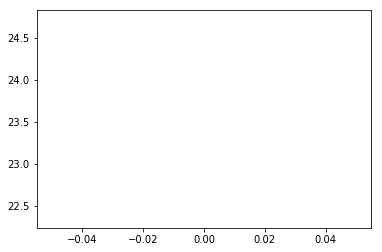

episode:  500  step:  11767  epsilon:  0.9023300000004445  score:  23.534


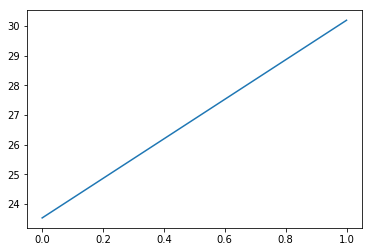

episode:  1000  step:  26865  epsilon:  0.7513500000011316  score:  30.196


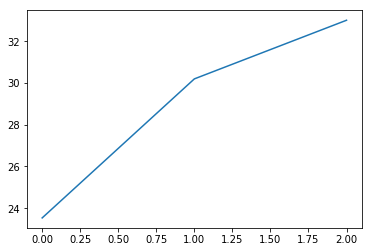

episode:  1500  step:  43368  epsilon:  0.5863200000018827  score:  33.006


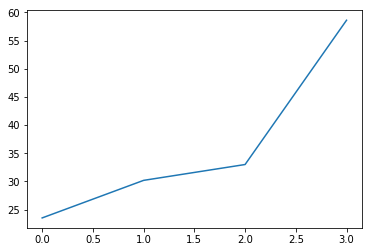

episode:  2000  step:  72667  epsilon:  0.2933300000020688  score:  58.598


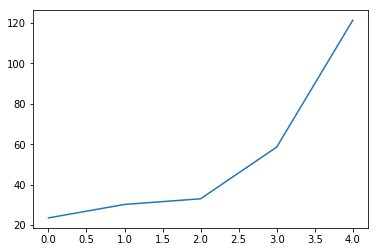

episode:  2500  step:  133354  epsilon:  0.05  score:  121.374


KeyboardInterrupt: 

In [7]:
env = gym.make('CartPole-v1')

Q_function_net = Q(state_space, action_space)
Q_target_net = Q(state_space, action_space)

optimizer = optim.Adam(Q_function_net.parameters(), lr=learning_rate) ## 그러므로 직접 뛰는 Q_player의 parameter만 변경.
Q_target_net.load_state_dict(Q_function_net.state_dict()) ## Q의 뉴럴넷 파라미터를 target에 복사!

step = 0 ## 총 step을 계산하기 위한 step.
score = 0
show_score = []
for epi in range(episode):
    obs = env.reset() ## 환경 초기화
    for i in range(maximum_steps):
        Q_values = Q_function_net(torch.Tensor(obs))
        action = epsilon_greedy(Q_values, action_space, epsilon)
        next_obs, reward, done, _ = env.step(action) ## _ 가 원래 info 정보를 가지고 있는데, 학습에 필요치 않음.

        mask = 0 if done else 1 ## 게임이 종료됬으면, done이 1이면 mask =0 그냥 생존유무 표시용.

        replay_buffer.append((obs, action, reward, next_obs, mask)) ## feature들을 저장

        obs = next_obs ## current state를 이제 next_state로 변경
        score += reward ## reward 갱신.
        step += 1
        
        if step > initial_exploration: ## 초기 exploration step을 넘어서면 학습 시작.
            epsilon -= epsilon_decay ## 학습해 감에 따라 epilon에 의존하기보단 학습된 정책에 의존되게.
            epsilon = max(epsilon, 0.05) ## 그래도 가끔씩 새로운 exploration을 위해 최소 0.05은 주기.
            random_mini_batch = random.sample(replay_buffer, batch_size) ## random하게 batch_size 만큼 데이터 뽑아줌.
            train(Q_function_net, Q_target_net, random_mini_batch)

        if done: ## 죽었다면 게임 초기화를 위한 반복문 탈출
            break
            
    if epi % print_interval == 0 and epi != 0:
        show_score.append(score/print_interval)
        plt.plot(show_score)
        plt.show()
        print('episode: ',epi,' step: ',step,' epsilon: ',epsilon,' score: ',score/print_interval)
        score = 0
env.close()